# **영화 흥행 예측 및 분류 프로젝트**

## 프로젝트 개요

본 프로젝트는 영화 데이터를 활용하여 다음 두 가지 문제를 해결하고자 합니다:

**문제 1)** Decision Tree를 이용한 영화 흥행 예측  
- 제작비, 장르, 감독, 배우, 개봉 시기 등의 특징을 활용
- 흥행에 가장 중요한 요인(feature) 파악
- 영화 제작 초기 단계에서 흥행 여부 예측 가능성 검증

**문제 2)** K-means++ 클러스터링을 통한 영화 분류  
- 수익, 평점, 인기도, 제작비를 기준으로 군집화
- 각 군집의 특징 분석
- 실제 영화 추천 시스템에 활용 가능한지 검토


---



## 1. 환경 설정 및 라이브러리 임포트

In [36]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, MultiLabelBinarizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    silhouette_score, davies_bouldin_score, calinski_harabasz_score
)
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

# 스타일 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# 랜덤 시드 고정
np.random.seed(42)

## 2. 데이터 로딩 및 탐색적 데이터 분석 (EDA)

### 2.1 데이터 로딩

In [37]:
# 데이터 로딩
url = "https://drive.google.com/file/d/1dNfchVc3XMTapg9C0QH2MZF-m24LEIT-/view?usp=sharing"
path = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(path)

print(f"데이터셋 크기: {df.shape[0]:,}개 영화, {df.shape[1]}개 컬럼")

데이터셋 크기: 4,803개 영화, 24개 컬럼


In [38]:
# 기본 정보 확인
df.head(10)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton
5,5,258000000,Fantasy Action Adventure,http://www.sonypictures.com/movies/spider-man3/,559,dual identity amnesia sandstorm love of one's ...,en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,...,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The battle within.,Spider-Man 3,5.9,3576,Tobey Maguire Kirsten Dunst James Franco Thoma...,"[{'name': 'Francine Maisler', 'gender': 1, 'de...",Sam Raimi
6,6,260000000,Animation Family,http://disney.go.com/disneypictures/tangled/,38757,hostage magic horse fairy tale musical,en,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,...,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,They're taking adventure to new lengths.,Tangled,7.4,3330,Zachary Levi Mandy Moore Donna Murphy Ron Perl...,"[{'name': 'John Lasseter', 'gender': 2, 'depar...",Byron Howard
7,7,280000000,Action Adventure Science Fiction,http://marvel.com/movies/movie/193/avengers_ag...,99861,marvel comic sequel superhero based on comic b...,en,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,134.279229,...,141.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,A New Age Has Come.,Avengers: Age of Ultron,7.3,6767,Robert Downey Jr. Chris Hemsworth Mark Ruffalo...,"[{'name': 'Danny Elfman', 'gender': 2, 'depart...",Joss Whedon
8,8,250000000,Adventure Fantasy Family,http://harrypotter.warnerbros.com/harrypottera...,767,witch magic broom

In [39]:
# 데이터 타입 및 결측치 확인
info_df = pd.DataFrame({
    'Data Type': df.dtypes,
    'Non-Null Count': df.count(),
    'Null Count': df.isnull().sum(),
    'Null %': (df.isnull().sum() / len(df) * 100).round(2)
})

print("\n=== 컬럼별 정보 ===")
print(info_df)


=== 컬럼별 정보 ===
                     Data Type  Non-Null Count  Null Count  Null %
index                    int64            4803           0    0.00
budget                   int64            4803           0    0.00
genres                  object            4775          28    0.58
homepage                object            1712        3091   64.36
id                       int64            4803           0    0.00
keywords                object            4391         412    8.58
original_language       object            4803           0    0.00
original_title          object            4803           0    0.00
overview                object            4800           3    0.06
popularity             float64            4803           0    0.00
production_companies    object            4803           0    0.00
production_countries    object            4803           0    0.00
release_date            object            4802           1    0.02
revenue                  int64            4803

### 2.2 수치형 변수 통계 요약

In [40]:
# 수치형 컬럼 통계
numeric_cols = ['budget', 'revenue', 'popularity', 'vote_average', 'vote_count', 'runtime']
df[numeric_cols].describe()

,budget,revenue,popularity,vote_average,vote_count,runtime
count,4.803000e+03,4.803000e+03,4803.000000,4803.000000,4803.000000,4801.000000
mean,2.904504e+07,8.226064e+07,21.492301,6.092172,690.217989,106.875859
std,4.072239e+07,1.628571e+08,31.816650,1.194612,1234.585891,22.611935
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,7.900000e+05,0.000000e+00,4.668070,5.600000,54.000000,94.000000
50%,1.500000e+07,1.917000e+07,12.921594,6.200000,235.000000,103.000000
75%,4.000000e+07,9.291719e+07,28.313505,6.800000,737.000000,118.000000
max,3.800000e+08,2.787965e+09,875.581305,10.000000,13752.000000,338.000000


In [41]:
# 0값 분석 (실질적 결측치)
zero_analysis = pd.DataFrame({
    '0값 개수': (df[numeric_cols] == 0).sum(),
    '0값 비율(%)': ((df[numeric_cols] == 0).sum() / len(df) * 100).round(2)
})

print("\n=== 0값 분석 (실질적 결측치) ===")
print(zero_analysis)


=== 0값 분석 (실질적 결측치) ===
              0값 개수  0값 비율(%)
budget         1037     21.59
revenue        1427     29.71
popularity        1      0.02
vote_average     63      1.31
vote_count       62      1.29
runtime          35      0.73


### 2.3 시각화: 주요 변수 분포

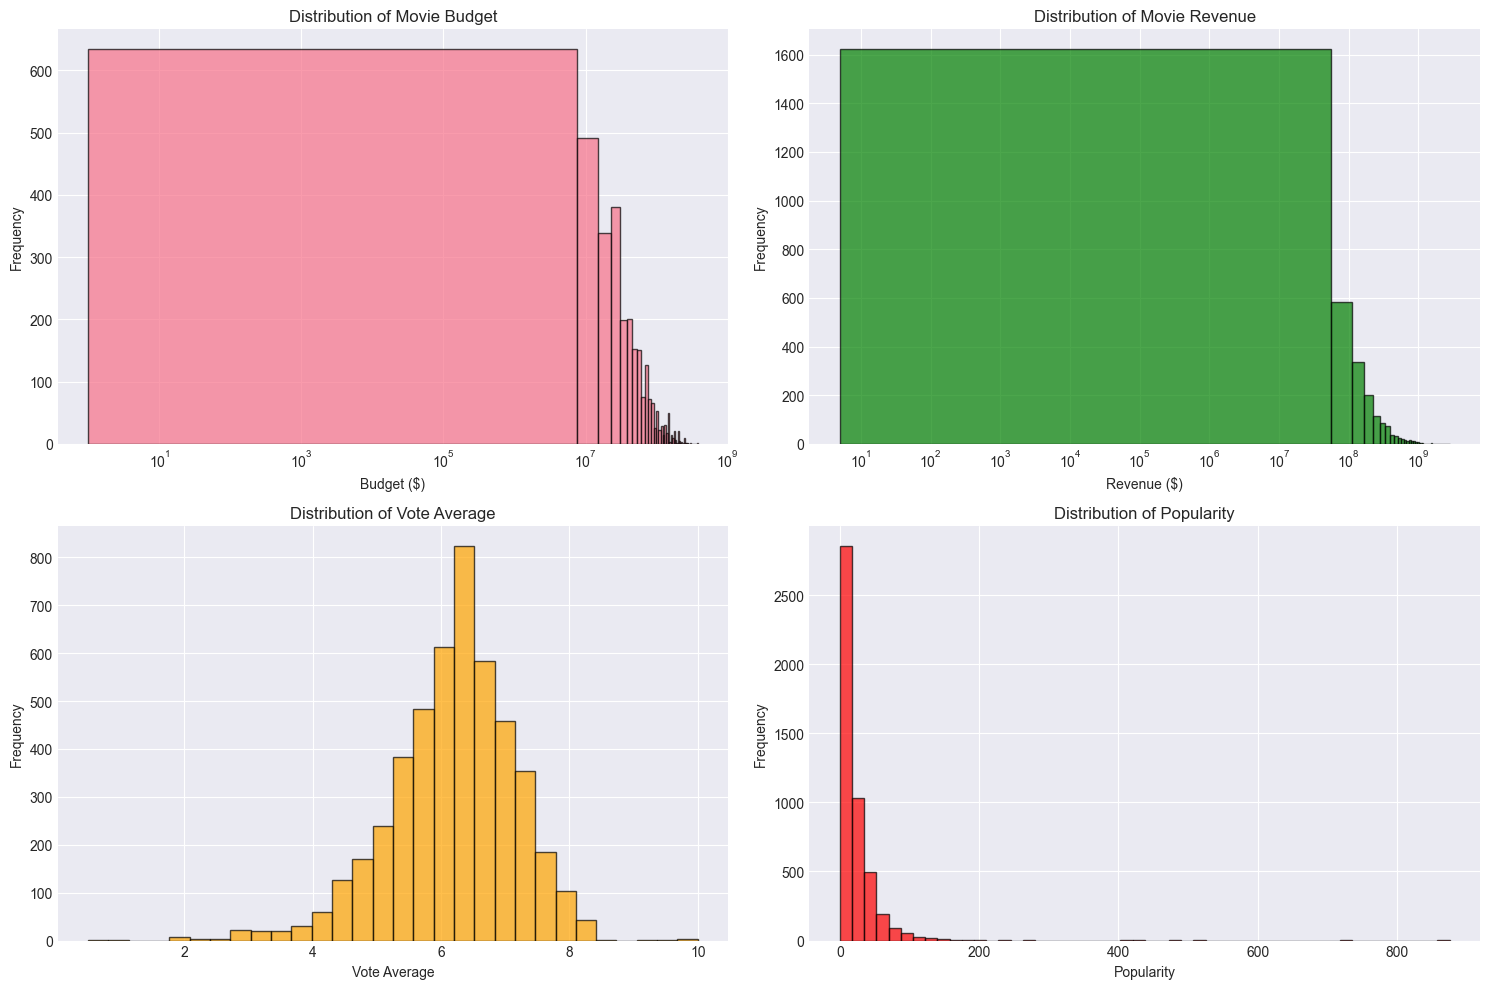

유효한 데이터 (budget > 0 AND revenue > 0): 3,229개 (67.23%)


In [42]:
# 제작비와 수익 분포 (로그 스케일)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 제작비 분포
df_valid = df[(df['budget'] > 0) & (df['revenue'] > 0)]
axes[0, 0].hist(df_valid['budget'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Budget ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Movie Budget')
axes[0, 0].set_xscale('log')

# 수익 분포
axes[0, 1].hist(df_valid['revenue'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Revenue ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Movie Revenue')
axes[0, 1].set_xscale('log')

# 평점 분포
axes[1, 0].hist(df[df['vote_average'] > 0]['vote_average'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Vote Average')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Vote Average')

# 인기도 분포
axes[1, 1].hist(df['popularity'], bins=50, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_xlabel('Popularity')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Popularity')

plt.tight_layout()
plt.show()

print(f"유효한 데이터 (budget > 0 AND revenue > 0): {len(df_valid):,}개 ({len(df_valid)/len(df)*100:.2f}%)")

### 2.4 장르 분석


=== 장르 분포 (Top 15) ===
        Genre  Count  Percentage
0       Drama   2297       47.82
1      Comedy   1722       35.85
2    Thriller   1259       26.21
3      Action   1153       24.01
4     Romance    890       18.53
5   Adventure    790       16.45
6       Crime    696       14.49
7     Science    530       11.03
8     Fiction    530       11.03
9      Horror    519       10.81
10     Family    510       10.62
11    Fantasy    418        8.70
12    Mystery    347        7.22
13  Animation    234        4.87
14    History    197        4.10


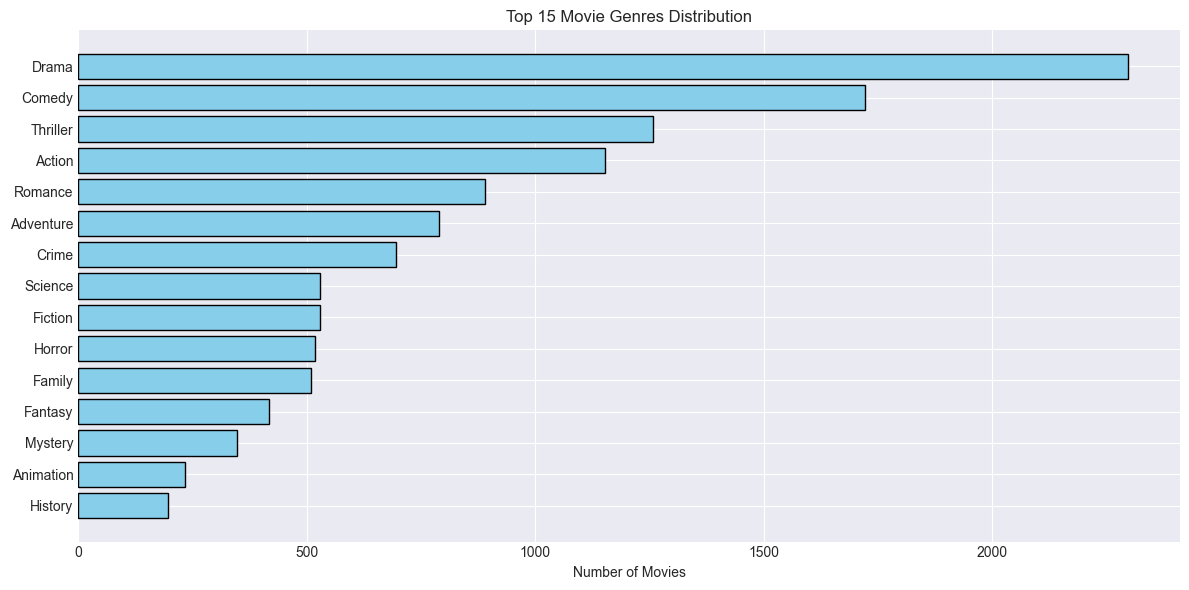

In [43]:
# 장르 분석
from collections import Counter

# 모든 장르 추출
all_genres = []
for genres in df['genres'].dropna():
    all_genres.extend(genres.split())

genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.most_common(15), columns=['Genre', 'Count'])
genre_df['Percentage'] = (genre_df['Count'] / len(df) * 100).round(2)

print("\n=== 장르 분포 (Top 15) ===")
print(genre_df)

# 장르 분포 시각화
plt.figure(figsize=(12, 6))
plt.barh(genre_df['Genre'], genre_df['Count'], color='skyblue', edgecolor='black')
plt.xlabel('Number of Movies')
plt.title('Top 15 Movie Genres Distribution')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 2.5 개봉 시기 분석

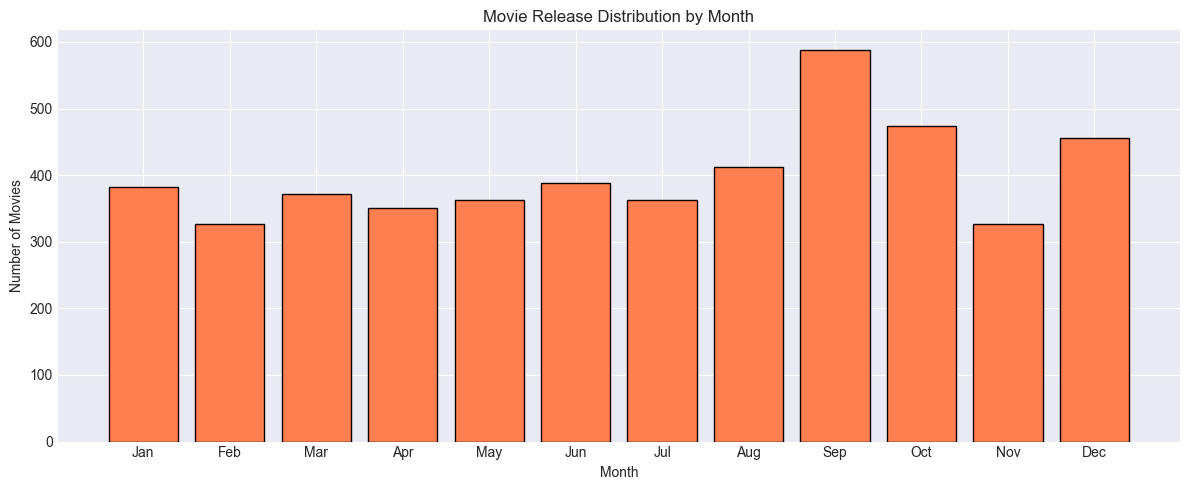


개봉 연도 범위: 1916 ~ 2017


In [44]:
# 개봉일 파싱
df['release_date_parsed'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date_parsed'].dt.year
df['release_month'] = df['release_date_parsed'].dt.month

# 월별 개봉 분포
month_counts = df['release_month'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
plt.bar(month_counts.index, month_counts.values, color='coral', edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.title('Movie Release Distribution by Month')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

print(f"\n개봉 연도 범위: {df['release_year'].min():.0f} ~ {df['release_year'].max():.0f}")

### 2.6 상관관계 분석

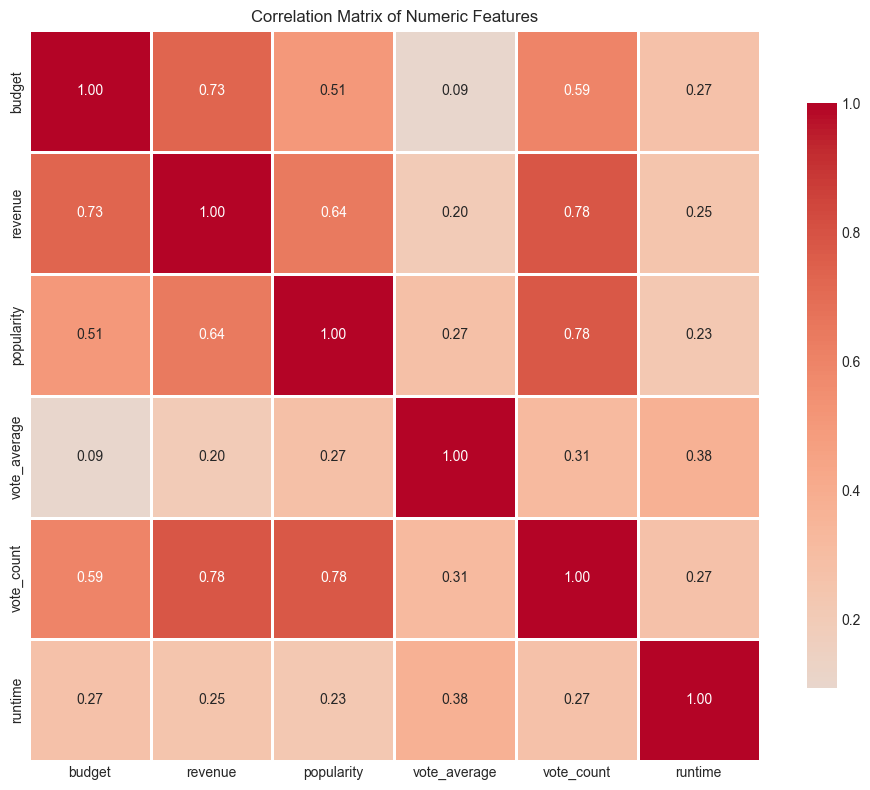

In [45]:
# 수치형 변수 간 상관관계
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

## 3. 데이터 전처리 및 Feature Engineering

### 3.1 유효한 데이터만 필터링

In [46]:
# 작업용 데이터프레임 생성
df_clean = df.copy()

print(f"원본 데이터: {len(df_clean):,}개")

# 필수 컬럼의 0값 제거
df_clean = df_clean[
    (df_clean['budget'] > 0) &
    (df_clean['revenue'] > 0) &
    (df_clean['vote_average'] > 0) &
    (df_clean['runtime'] > 0)
]

print(f"필터링 후 (budget, revenue, vote_average, runtime > 0): {len(df_clean):,}개 ({len(df_clean)/len(df)*100:.2f}%)")

# 필수 컬럼의 결측치 제거
essential_cols = ['genres', 'release_date', 'director']
df_clean = df_clean.dropna(subset=essential_cols)

print(f"결측치 제거 후: {len(df_clean):,}개 ({len(df_clean)/len(df)*100:.2f}%)")

원본 데이터: 4,803개
필터링 후 (budget, revenue, vote_average, runtime > 0): 3,227개 (67.19%)
결측치 제거 후: 3,225개 (67.15%)


### 3.2 Feature Engineering

In [47]:
# 파생 변수 생성
# 1) 수익성 지표
df_clean['profit'] = df_clean['revenue'] - df_clean['budget']
df_clean['roi'] = ((df_clean['revenue'] - df_clean['budget']) / df_clean['budget'] * 100)
df_clean['is_profitable'] = (df_clean['revenue'] > df_clean['budget']).astype(int)

# 2) 시간 특징
df_clean['release_date_parsed'] = pd.to_datetime(df_clean['release_date'], errors='coerce')
df_clean['release_year'] = df_clean['release_date_parsed'].dt.year
df_clean['release_month'] = df_clean['release_date_parsed'].dt.month
df_clean['release_season'] = ((df_clean['release_month'] - 1) // 3 + 1)  # 1=겨울, 2=봄, 3=여름, 4=가을
df_clean['is_summer_release'] = df_clean['release_month'].isin([6, 7, 8]).astype(int)
df_clean['is_holiday_release'] = df_clean['release_month'].isin([11, 12]).astype(int)

# 3) 제작비 카테고리
df_clean['budget_category'] = pd.cut(
    df_clean['budget'],
    bins=[0, 5e6, 2e7, 1e8, np.inf],
    labels=['Low', 'Medium', 'High', 'Blockbuster']
)

# 4) 장르 수
df_clean['num_genres'] = df_clean['genres'].str.split().str.len()

# 5) 캐스트 수
df_clean['num_cast'] = df_clean['cast'].fillna('').str.split().str.len()

# 6) 인기도-평점 조합
df_clean['popularity_rating'] = df_clean['popularity'] * df_clean['vote_average']
df_clean['weighted_rating'] = df_clean['vote_average'] * np.log1p(df_clean['vote_count'])

print("\n=== 파생 변수 생성 됨 ===")
print(f"추가된 컬럼 수: 13개")
print(f"총 컬럼 수: {df_clean.shape[1]}개")


=== 파생 변수 생성 됨 ===
추가된 컬럼 수: 13개
총 컬럼 수: 38개


### 3.3 장르 One-Hot Encoding

In [48]:
# 장르를 리스트로 변환 (다중 단어 장르 처리)
# "Science Fiction"을 "ScienceFiction"으로 변환하여 하나의 장르로 취급
df_clean['genres'] = df_clean['genres'].str.replace('Science Fiction', 'ScienceFiction')


# 장르를 리스트로 변환
genres_list = df_clean['genres'].str.split().tolist()

# MultiLabelBinarizer 사용
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(genres_list)
genres_encoded_df = pd.DataFrame(genres_encoded, columns=[f'genre_{g}' for g in mlb.classes_], index=df_clean.index)

# 원본 데이터프레임에 병합
df_clean = pd.concat([df_clean, genres_encoded_df], axis=1)

print(f"\n장르 One-Hot Encoding 됨: {len(mlb.classes_)}개 장르")
print(f"장르 목록: {', '.join(mlb.classes_)}")


장르 One-Hot Encoding 됨: 19개 장르
장르 목록: Action, Adventure, Animation, Comedy, Crime, Documentary, Drama, Family, Fantasy, Foreign, History, Horror, Music, Mystery, Romance, ScienceFiction, Thriller, War, Western


### 3.4 타겟 변수 생성 (V1: 실질적 수익 기준)

**V1 타겟 정의**: revenue >= 2 × budget

**선택 이유**:
1. 영화 산업 표준: 제작비의 2배 이상 수익을 "실질적 성공"으로 간주
2. 마케팅 비용 고려: 제작비 외 마케팅, 배급 비용 포함 시 약 2배 필요


=== 흥행 여부 분포 ===
흥행 (1): 1,809개 (56.09%)
비흥행 (0): 1,416개 (43.91%)


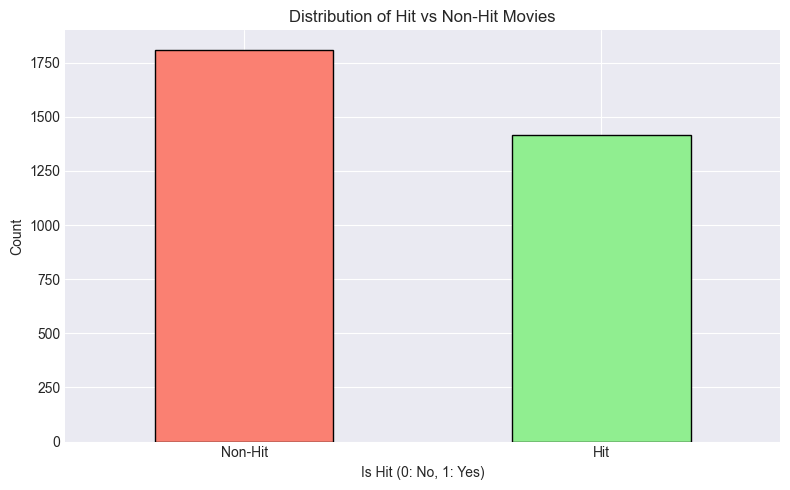

In [49]:
# 타겟 변수 생성
df_clean['hit'] = (df_clean['revenue'] >= 2 * df_clean['budget']).astype(int)

# release_date를 release_year(연), release_month(월) 꼴로 분해
df_clean['release_date'] = pd.to_datetime(df_clean['release_date'], errors='coerce')
df_clean['release_year'] = df_clean['release_date'].dt.year
df_clean['release_month'] = df_clean['release_date'].dt.month

hit_distribution = df_clean['hit'].value_counts()
print("\n=== 흥행 여부 분포 ===")
print(f"흥행 (1): {hit_distribution[1]:,}개 ({hit_distribution[1]/len(df_clean)*100:.2f}%)")
print(f"비흥행 (0): {hit_distribution[0]:,}개 ({hit_distribution[0]/len(df_clean)*100:.2f}%)")

# 시각화
plt.figure(figsize=(8, 5))
hit_distribution.plot(kind='bar', color=['salmon', 'lightgreen'], edgecolor='black')
plt.xlabel('Is Hit (0: No, 1: Yes)')
plt.ylabel('Count')
plt.title('Distribution of Hit vs Non-Hit Movies')
plt.xticks([0, 1], ['Non-Hit', 'Hit'], rotation=0)
plt.tight_layout()
plt.show()

# **문제 1**: Decision Tree 기반 흥행 예측 (V1 타겟)

### **(1) 개봉 후 알 수 있는 정보들을 feature에 포함하였을 시**

### 1. Feature 선택 및 데이터 준비

In [50]:
feature_cols = ['budget', 'popularity', 'vote_average', 'vote_count', 'runtime',    'release_month', 'release_season', 'release_year', 'num_genres', 'num_cast',    'is_summer_release', 'is_holiday_release',    'popularity_rating', 'weighted_rating'] + [col for col in df_clean.columns if col.startswith('genre_')]
df_clean[feature_cols]

,budget,popularity,vote_average,vote_count,runtime,release_month,release_season,release_year,num_genres,num_cast,...,genre_Foreign,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_ScienceFiction,genre_Thriller,genre_War,genre_Western
0,237000000,150.437577,7.2,11800,162.0,12,4,2009,5,10,...,0,0,0,0,0,0,1,0,0,0
1,300000000,139.082615,6.9,4500,169.0,5,2,2007,3,10,...,0,0,0,0,0,0,0,0,0,0
2,245000000,107.376788,6.3,4466,148.0,10,4,2015,3,10,...,0,0,0,0,0,0,0,0,0,0
3,250000000,112.312950,7.6,9106,165.0,7,3,2012,4,10,...,0,0,0,0,0,0,0,1,0,0
4,260000000,43.926995,6.1,2124,132.0,3,1,2012,4,11,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4773,27000,19.748658,7.4,755,92.0,9,3,1994,1,10,...,0,0,0,0,0,0,0,0,0,0
4788,12000,4.553644,6.2,110,93.0,3,1,1972,3,10,...,0,0,1,0,0,0,0,0,0,0
4792,20000,0.212443,7.4,63,111.0,11,4,1997,4,10,...,0,0,1,0,1,0,0,1,0,0
4796,7000,23.307949,6.9,658,77.0,10,4,2004,4,10,...,0,0,0,0,0,0,1,1,0,0


In [51]:
# Decision Tree를 위한 특징 선택
feature_cols = ['budget', 'popularity', 'vote_average', 'vote_count', 'runtime',    'release_month', 'release_season', 'release_year', 'num_genres', 'num_cast',    'is_summer_release', 'is_holiday_release',    'popularity_rating', 'weighted_rating'] + [col for col in df_clean.columns if col.startswith('genre_')]

X = df_clean[feature_cols]
y = df_clean['hit']
print(f"\n특징 개수: {len(feature_cols)}개")
print(f"샘플 수: {len(X):,}개")
print(f"\n주요 특징 (처음 20개):")
print(feature_cols[:20])


특징 개수: 33개
샘플 수: 3,225개

주요 특징 (처음 20개):
['budget', 'popularity', 'vote_average', 'vote_count', 'runtime', 'release_month', 'release_season', 'release_year', 'num_genres', 'num_cast', 'is_summer_release', 'is_holiday_release', 'popularity_rating', 'weighted_rating', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary']


### 2. Train Set 및 Test Set 분할

In [52]:
# 80/20 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n=== 데이터 분할 ===")
print(f"Train set: {len(X_train):,}개")
print(f"Test set: {len(X_test):,}개")
print(f"\nTrain set - 흥행 비율: {y_train.mean()*100:.2f}%")
print(f"Test set - 흥행 비율: {y_test.mean()*100:.2f}%")


=== 데이터 분할 ===
Train set: 2,580개
Test set: 645개

Train set - 흥행 비율: 56.09%
Test set - 흥행 비율: 56.12%


### 3. Decision Tree 모델 학습

In [53]:
# Decision Tree 모델 (과적합 방지를 위해 max_depth 제한)
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

# 학습
dt_model.fit(X_train, y_train)

print("\nDecision Tree 모델 학습 됨")
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")


Decision Tree 모델 학습 됨
Tree depth: 10
Number of leaves: 142


### 4. 모델 평가

In [54]:
# 예측
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

# 성능 지표 계산
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\n=== Decision Tree 성능 평가 ===")
print(f"\nTrain Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"\nTest Set Metrics:")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")
print(f"  F1-Score: {test_f1:.4f}")

# 분류 리포트
print(f"\n{classification_report(y_test, y_test_pred, target_names=['Non-Hit', 'Hit'])}")


=== Decision Tree 성능 평가 ===

Train Accuracy: 0.8322
Test Accuracy: 0.7070

Test Set Metrics:
  Precision: 0.7396
  Recall: 0.7376
  F1-Score: 0.7386

              precision    recall  f1-score   support

     Non-Hit       0.67      0.67      0.67       283
         Hit       0.74      0.74      0.74       362

    accuracy                           0.71       645
   macro avg       0.70      0.70      0.70       645
weighted avg       0.71      0.71      0.71       645



### 5. Confusion Matrix

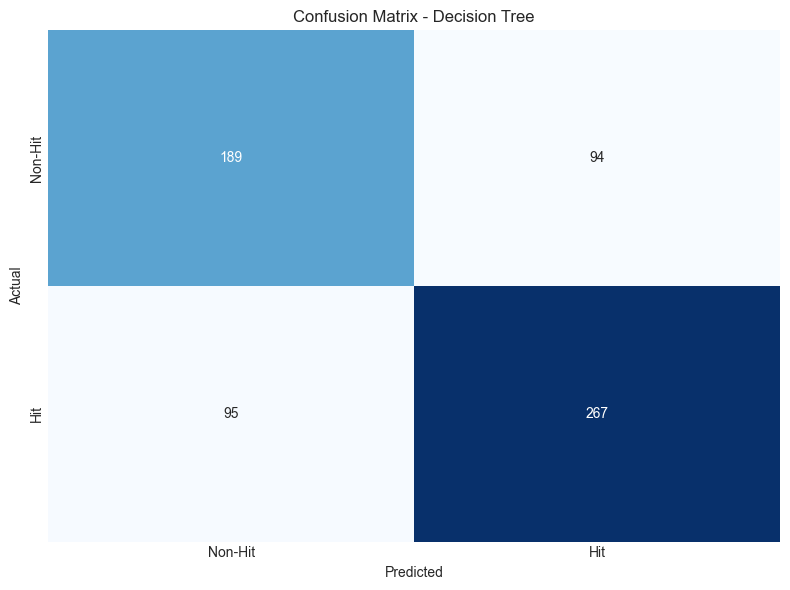


True Negatives: 189
False Positives: 94
False Negatives: 95
True Positives: 267


In [55]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Hit', 'Hit'],
            yticklabels=['Non-Hit', 'Hit'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

### 6. ROC Curve 및 AUC

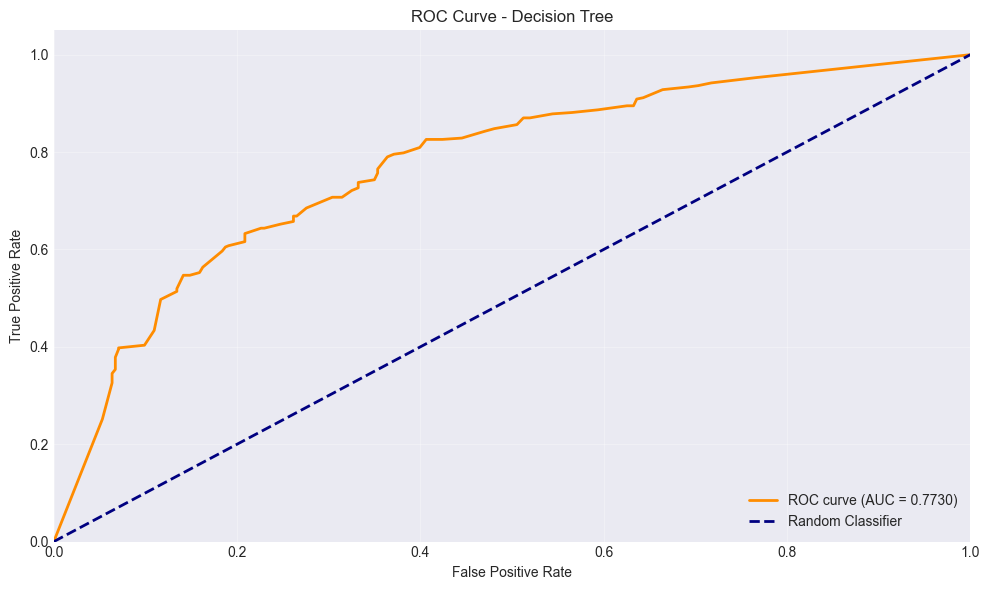


ROC-AUC Score: 0.7730


In [56]:
# ROC Curve
y_test_proba = dt_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nROC-AUC Score: {roc_auc:.4f}")

### 7. Feature Importance 분석


=== Top 20 중요한 특징 ===
             feature  importance
     weighted_rating    0.300229
          vote_count    0.172394
              budget    0.162217
        release_year    0.142663
   popularity_rating    0.037309
             runtime    0.030761
          num_genres    0.028518
          popularity    0.025146
        vote_average    0.020306
       release_month    0.014015
        genre_Comedy    0.011205
         genre_Drama    0.010735
            num_cast    0.010661
      genre_Thriller    0.008927
        genre_Horror    0.007539
         genre_Crime    0.007030
     genre_Adventure    0.005368
genre_ScienceFiction    0.003382
        genre_Family    0.001594
     genre_Animation    0.000000


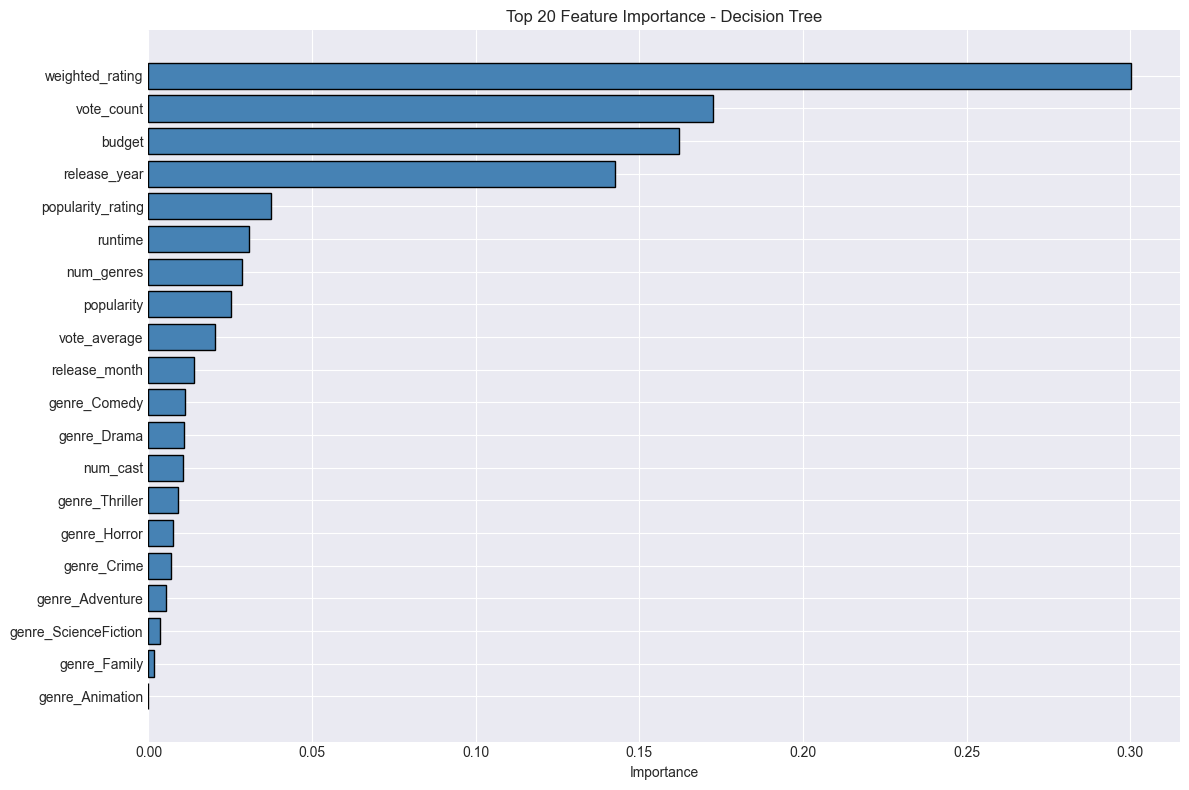

In [57]:
# Feature Importance 추출
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 중요 특징
top_20_features = feature_importance.head(20)

print("\n=== Top 20 중요한 특징 ===")
print(top_20_features.to_string(index=False))

# 시각화
plt.figure(figsize=(12, 8))
plt.barh(top_20_features['feature'], top_20_features['importance'], color='steelblue', edgecolor='black')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance - Decision Tree')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 8. Decision Tree 시각화 (일부)

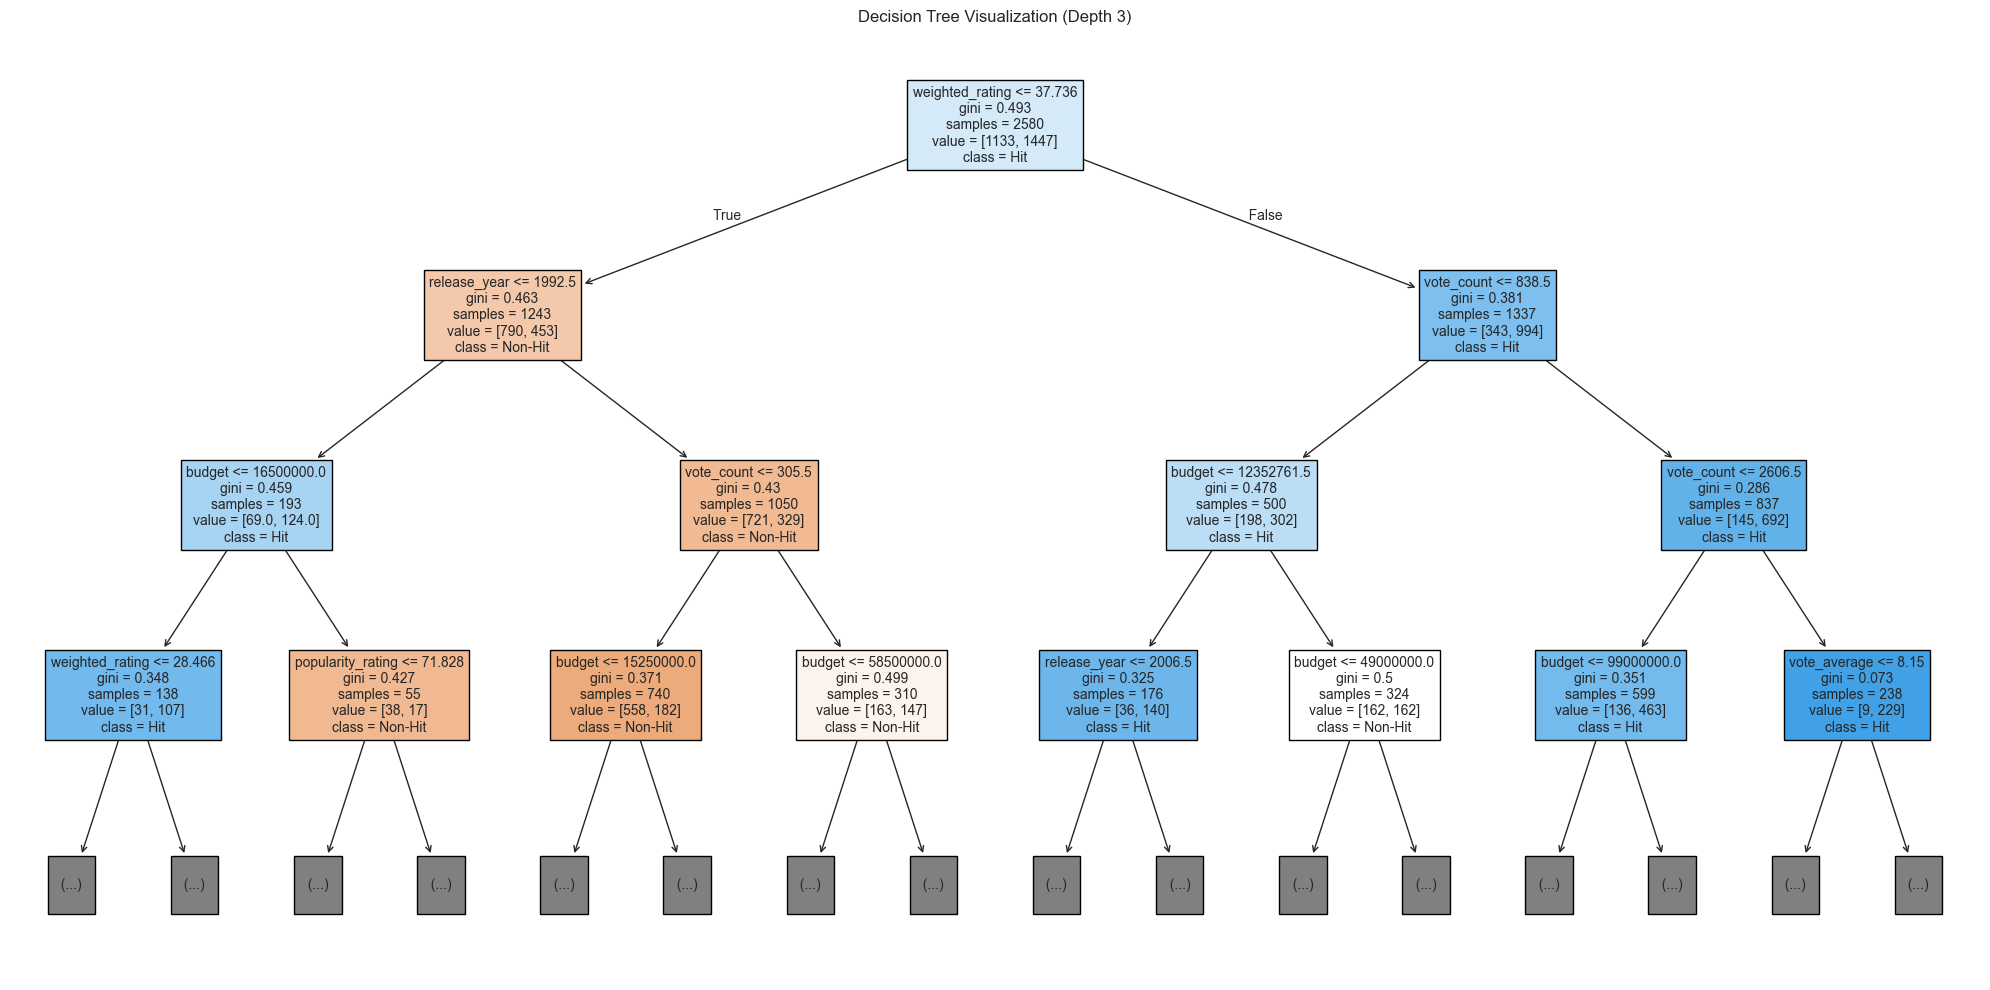

In [58]:
# 트리 일부 시각화 (max_depth=3까지만)
plt.figure(figsize=(20, 10))
plot_tree(dt_model,
          max_depth=3,
          feature_names=feature_cols,
          class_names=['Non-Hit', 'Hit'],
          filled=True,
          fontsize=10)
plt.title('Decision Tree Visualization (Depth 3)')
plt.tight_layout()
plt.show()

# **(1)에서의 문제점**

- 예측 시점에 알 수 없는 정보(feature)를 학습에 사용하여, 과도하게 낙관적인 성능을 보이는 현상이 발생함(Data Leakage).

- 이에 따라 '관객이 많이 투표한 영화는 흥행한다'와 같은 영화 데이터의 순환 논리가 발생하며 모델의 strong feature 중 상당수가 개봉 후 알 수 있는 정보에 의존하므로, 제작 단계에서는 해당 모델을 사용할 수 없음.

- 따라서, 실제 모델을 사용하기 위해서는 개봉 후 알 수 있는 정보를 없앤 데이터로 모델을 학습시켜야 함.

### → **(2)-1, (2)-2** 개봉 후 알 수 있는 정보를 feature에서 제거 후 문제 해결 시도


---



### **(2)-1. 개봉 후 알 수 있는 정보들을 feature에서 제거했을 시 - Decision Tree 모델**

### 1. Feature 선택 및 데이터 준비

In [59]:
feature_cols = ['budget', 'popularity', 'vote_average', 'vote_count', 'runtime',    'release_month', 'release_season', 'release_year', 'num_genres', 'num_cast',    'is_summer_release', 'is_holiday_release',    'popularity_rating', 'weighted_rating'] + [col for col in df_clean.columns if col.startswith('genre_')]
df_clean[feature_cols]

,budget,popularity,vote_average,vote_count,runtime,release_month,release_season,release_year,num_genres,num_cast,...,genre_Foreign,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_ScienceFiction,genre_Thriller,genre_War,genre_Western
0,237000000,150.437577,7.2,11800,162.0,12,4,2009,5,10,...,0,0,0,0,0,0,1,0,0,0
1,300000000,139.082615,6.9,4500,169.0,5,2,2007,3,10,...,0,0,0,0,0,0,0,0,0,0
2,245000000,107.376788,6.3,4466,148.0,10,4,2015,3,10,...,0,0,0,0,0,0,0,0,0,0
3,250000000,112.312950,7.6,9106,165.0,7,3,2012,4,10,...,0,0,0,0,0,0,0,1,0,0
4,260000000,43.926995,6.1,2124,132.0,3,1,2012,4,11,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4773,27000,19.748658,7.4,755,92.0,9,3,1994,1,10,...,0,0,0,0,0,0,0,0,0,0
4788,12000,4.553644,6.2,110,93.0,3,1,1972,3,10,...,0,0,1,0,0,0,0,0,0,0
4792,20000,0.212443,7.4,63,111.0,11,4,1997,4,10,...,0,0,1,0,1,0,0,1,0,0
4796,7000,23.307949,6.9,658,77.0,10,4,2004,4,10,...,0,0,0,0,0,0,1,1,0,0


In [60]:
# Decision Tree를 위한 특징 선택 (popularity, vote_average, vote_count, popularity_rating, weighted_rating 5개의 feature를 제거)
feature_cols = ['budget', 'runtime',    'release_month', 'release_season', 'release_year', 'num_genres', 'num_cast',    'is_summer_release', 'is_holiday_release'] + [col for col in df_clean.columns if col.startswith('genre_')]

X = df_clean[feature_cols]
y = df_clean['hit']
print(f"\n특징 개수: {len(feature_cols)}개")
print(f"샘플 수: {len(X):,}개")
print(f"\n주요 특징 (처음 20개):")
print(feature_cols[:20])


특징 개수: 28개
샘플 수: 3,225개

주요 특징 (처음 20개):
['budget', 'runtime', 'release_month', 'release_season', 'release_year', 'num_genres', 'num_cast', 'is_summer_release', 'is_holiday_release', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_Foreign', 'genre_History']


### 2. Train Set 및 Test Set 분할

In [61]:
# 80/20 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n=== 데이터 분할 ===")
print(f"Train set: {len(X_train):,}개")
print(f"Test set: {len(X_test):,}개")
print(f"\nTrain set - 흥행 비율: {y_train.mean()*100:.2f}%")
print(f"Test set - 흥행 비율: {y_test.mean()*100:.2f}%")


=== 데이터 분할 ===
Train set: 2,580개
Test set: 645개

Train set - 흥행 비율: 56.09%
Test set - 흥행 비율: 56.12%


### 3. Decision Tree 모델 학습

In [62]:
# Decision Tree 모델 (과적합 방지를 위해 max_depth 제한)
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

# 학습
dt_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,20
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### 4. 모델 평가

In [63]:
# 예측
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

# 성능 지표 계산
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\n=== Decision Tree (Post-release Feature 제거 후) 성능 평가 ===")
print(f"\nTrain Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"\nTest Set Metrics:")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")
print(f"  F1-Score: {test_f1:.4f}")

# 분류 리포트
print(f"\n{classification_report(y_test, y_test_pred, target_names=['Non-Hit', 'Hit'])}")


=== Decision Tree (Post-release Feature 제거 후) 성능 평가 ===

Train Accuracy: 0.6690
Test Accuracy: 0.5860

Test Set Metrics:
  Precision: 0.6309
  Recall: 0.6326
  F1-Score: 0.6317

              precision    recall  f1-score   support

     Non-Hit       0.53      0.53      0.53       283
         Hit       0.63      0.63      0.63       362

    accuracy                           0.59       645
   macro avg       0.58      0.58      0.58       645
weighted avg       0.59      0.59      0.59       645



### 5. Confusion Matrix

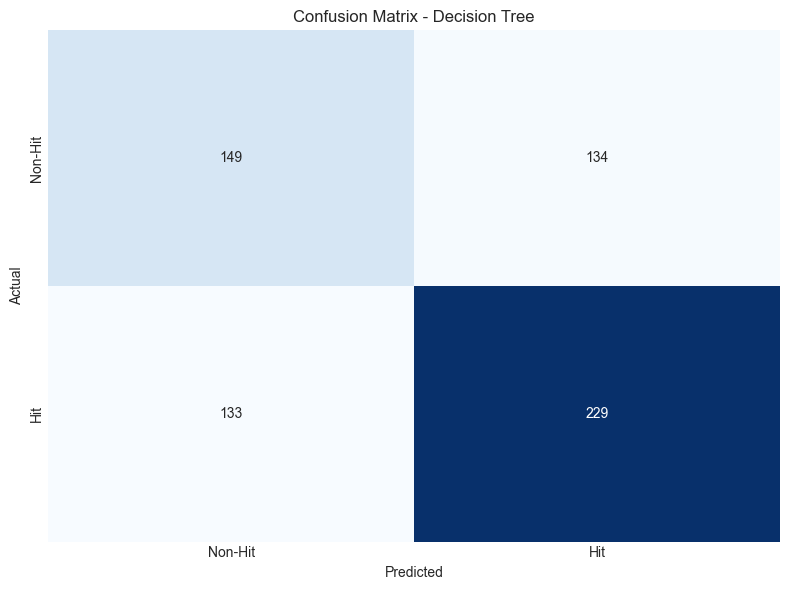


True Negatives: 149
False Positives: 134
False Negatives: 133
True Positives: 229


In [64]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Hit', 'Hit'],
            yticklabels=['Non-Hit', 'Hit'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

### 6. ROC Curve 및 AUC

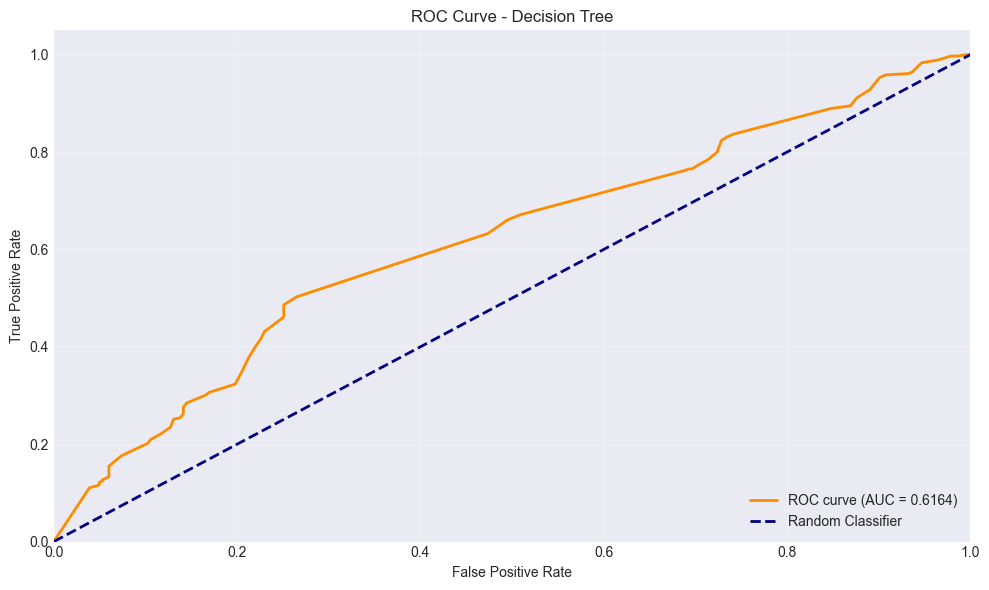


ROC-AUC Score: 0.6164


In [65]:
# ROC Curve
y_test_proba = dt_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nROC-AUC Score: {roc_auc:.4f}")

# **(2)-1에서의 문제점**

- 개봉 후 알 수 있는 feature(Post-release 정보)를 제외한 데이터에 decision tree 모델을 사용하면, AUC=0.6164로 모델의 성능이 급격히 저하됨.

- 제거된 feature 5개는 popularity, vote_average, vote_count, popularity_rating, weighted_rating으로, 전부 연속형 feature이고 이들은 (1)에서의 Decision Tree 모델에 큰 영향을 주는 strong feature였음.

- 따라서, Post-release 정보를 제외한다면 모델은 정보량이 훨씬 약한 feature들에 의존해야 하며 이들 중 대부분이 sparse함.

- 결국, 고차원 희소 데이터를 잘 활용하지 못하고 강력한 Continuous feature가 없으면 split 성능이 급감하는 Decision Tree 모델은 이 경우 사용하기 곤란함

### → **(2)-2** Gradient Boosting(GBM) 모델을 사용하여 문제 해결 시도


---



### **(2)-2. 개봉 후 알 수 있는 정보들을 feature에서 제거했을 시 -Gradient Boosting 모델**

### 3. Gradient Boosting 모델 학습

In [ ]:
# 클래스에 따른 가중치
# class_0_weight = 0.53
# class_1_weight = 0.47

class_0_weight = 362
class_1_weight = 283

# 훈련 데이터에 대한 가중치 배열 생성
sample_weights = np.array([class_0_weight if label == 0 else class_1_weight for label in y_train])

# gb_model = GradientBoostingClassifier(
#     n_estimators=500,
#     random_state=42,
#     max_depth=3,
#     learning_rate=0.03,
#     subsample=0.8,
#     min_samples_leaf=3
# )

# gb_model.fit(X_train, y_train, sample_weight=sample_weights)

xgb_model = XGBClassifier(
    n_estimators=500,
    random_state=42,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=5,
    eval_metric='logloss',
    scale_pos_weight=class_0_weight/class_1_weight)
xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


### 4. 모델 평가

In [67]:
# 예측
# y_train_pred = gb_model.predict(X_train)
# y_test_pred = gb_model.predict(X_test)

y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# 성능 지표 계산
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\n=== Gradient Boosting 성능 평가 ===")
print(f"\nTrain Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"\nTest Set Metrics:")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")
print(f"  F1-Score: {test_f1:.4f}")

# 분류 리포트
print(f"\n{classification_report(y_test, y_test_pred, target_names=['Non-Hit', 'Hit'])}")


=== Gradient Boosting 성능 평가 ===

Train Accuracy: 0.8155
Test Accuracy: 0.6403

Test Set Metrics:
  Precision: 0.6617
  Recall: 0.7348
  F1-Score: 0.6963

              precision    recall  f1-score   support

     Non-Hit       0.60      0.52      0.56       283
         Hit       0.66      0.73      0.70       362

    accuracy                           0.64       645
   macro avg       0.63      0.63      0.63       645
weighted avg       0.64      0.64      0.64       645



### 5. Confusion Matrix

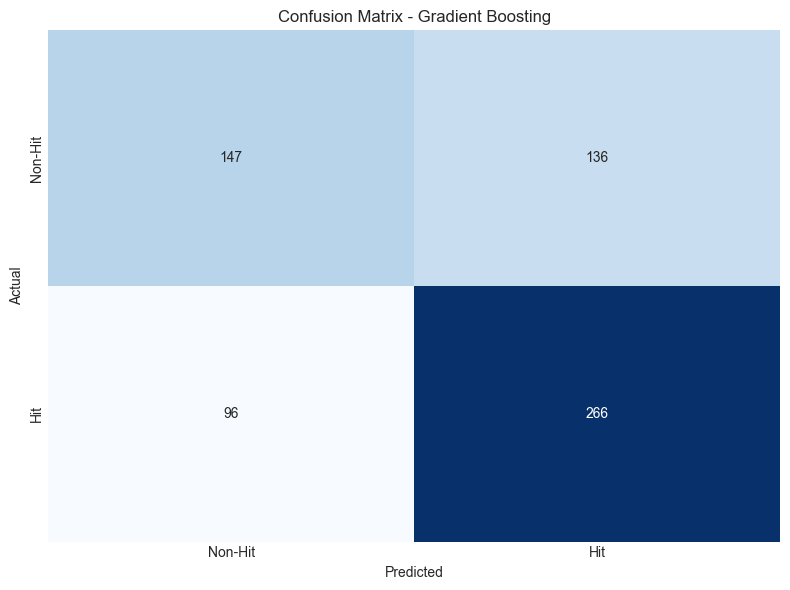


True Negatives: 147
False Positives: 136
False Negatives: 96
True Positives: 266


In [68]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Hit', 'Hit'],
            yticklabels=['Non-Hit', 'Hit'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

### 6. ROC Curve 및 AUC

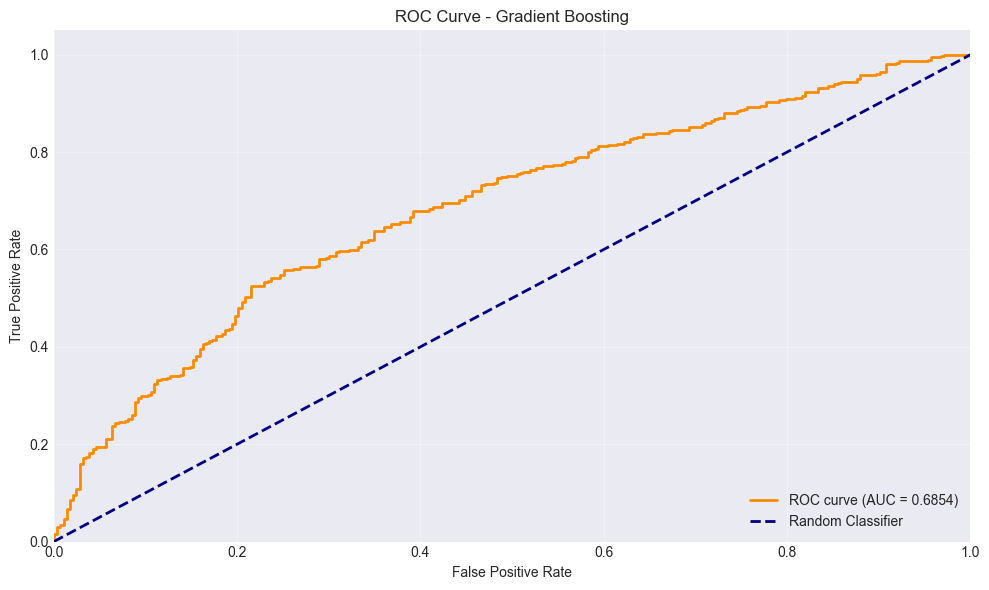


ROC-AUC Score: 0.6854


In [69]:
# ROC Curve
# y_test_proba = gb_model.predict_proba(X_test)[:, 1]
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nROC-AUC Score: {roc_auc:.4f}")

### 7. Feature Importance 분석

In [70]:
# Feature Importance 추출
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 중요 특징
top_20_features = feature_importance.head(20)

print("\n=== Top 20 중요한 특징 ===")
print(top_20_features.to_string(index=False))

# 시각화
plt.figure(figsize=(12, 8))
plt.barh(top_20_features['feature'], top_20_features['importance'], color='steelblue', edgecolor='black')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance - Gradient Boosting')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

NameError: name 'gb_model' is not defined

## **문제 2**: K-means++ 클러스터링 (V1 타겟)

### **(1) StandardScaler를 사용한 군집화**

### 1. 클러스터링을 위한 데이터 준비

In [ ]:
clustering_features = ['budget', 'runtime', 'popularity', 'vote_average']
X_cluster = df_clean[clustering_features].copy()
print(f"\n=== K-means++ 클러스터링 데이터 ===")
print(f"샘플 수: {len(X_cluster):,}개")
print(f"특징: {clustering_features}")
print(f"\n기본 통계:")
print(X_cluster.describe())


=== K-means++ 클러스터링 데이터 ===
샘플 수: 3,225개
특징: ['budget', 'runtime', 'popularity', 'vote_average']

기본 통계:
             budget      runtime   popularity  vote_average
count  3.225000e+03  3225.000000  3225.000000    3225.00000
mean   4.070121e+07   110.723411    29.069419       6.31355
std    4.440431e+07    20.973909    36.173911       0.85985
min    1.000000e+00    41.000000     0.019984       2.30000
25%    1.050000e+07    96.000000    10.484642       5.80000
50%    2.500000e+07   107.000000    20.428237       6.30000
75%    5.500000e+07   121.000000    37.355826       6.90000
max    3.800000e+08   338.000000   875.581305       8.50000


### 2. 데이터 스케일링

In [ ]:
# StandardScaler 적용 (K-means는 스케일에 민감)
scaler = StandardScaler()

X_cluster_scaled = scaler.fit_transform(X_cluster)

print("\nStandardScaler 적용 됨")
print(f"스케일링 후 평균: {X_cluster_scaled.mean(axis=0)}")
print(f"스케일링 후 표준편차: {X_cluster_scaled.std(axis=0)}")


StandardScaler 적용 됨
스케일링 후 평균: [0.00000000e+00 2.82013861e-16 7.05034653e-17 1.53345037e-15]
스케일링 후 표준편차: [1. 1. 1. 1.]


### 3. 최적 클러스터 수 결정 (Elbow Method)

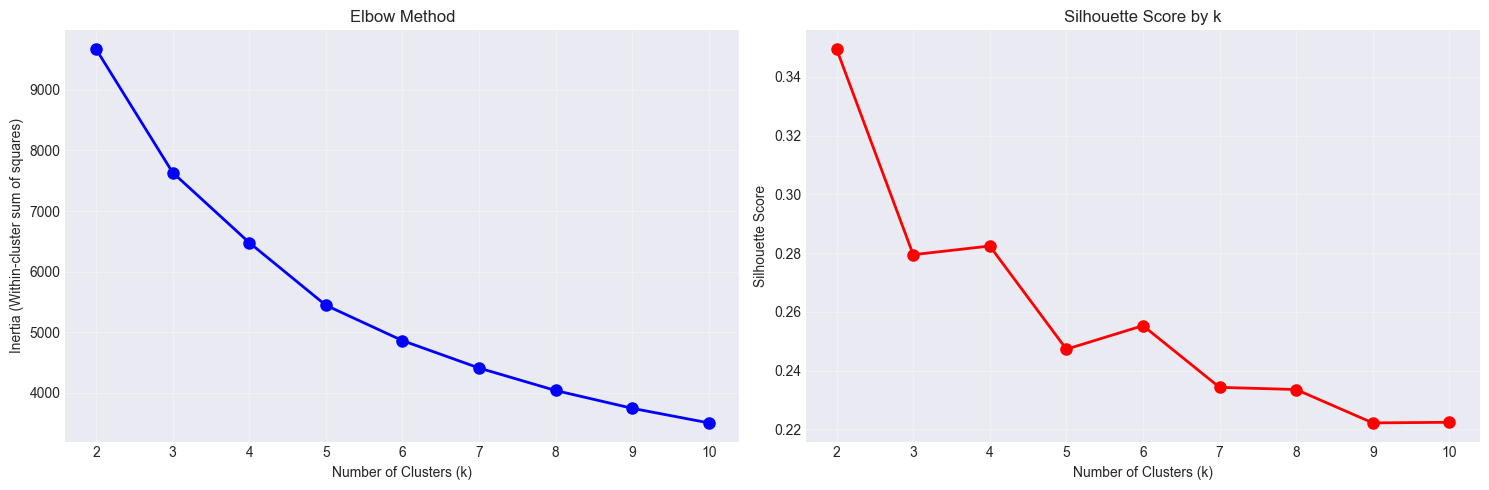


최적 클러스터 수 (Silhouette Score 기준): k = 2
최고 Silhouette Score: 0.3495


In [ ]:
# Elbow Method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Curve
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0].set_title('Elbow Method')
axes[0].grid(alpha=0.3)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score by k')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 최적 k 찾기
best_k = K_range[np.argmax(silhouette_scores)]
print(f"\n최적 클러스터 수 (Silhouette Score 기준): k = {best_k}")
print(f"최고 Silhouette Score: {max(silhouette_scores):.4f}")

### 4. K-means++ 클러스터링 수행

In [ ]:
# 인덱스 리셋 및 클러스터링
df_clean = df_clean.reset_index(drop=True)
X_cluster = df_clean[clustering_features].copy()
X_cluster_scaled = scaler.transform(X_cluster)

kmeans_final = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_cluster_scaled)
df_clean['cluster'] = cluster_labels

print(f"\nK-means++ 클러스터링 (k={best_k})")
print(f"\n클러스터별 영화 수:")
print(df_clean['cluster'].value_counts().sort_index())


K-means++ 클러스터링 (k=2)

클러스터별 영화 수:
cluster
0    2355
1     870
Name: count, dtype: int64


### 5. 클러스터 평가

In [ ]:
# 평가 지표 계산
silhouette = silhouette_score(X_cluster_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(X_cluster_scaled, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_cluster_scaled, cluster_labels)

print("\n=== 클러스터링 평가 지표 ===")
print(f"Silhouette Score: {silhouette:.4f} (높을수록 좋음, -1~1)")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f} (낮을수록 좋음)")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.2f} (높을수록 좋음)")


=== 클러스터링 평가 지표 ===
Silhouette Score: 0.3495 (높을수록 좋음, -1~1)
Davies-Bouldin Index: 1.4429 (낮을수록 좋음)
Calinski-Harabasz Score: 1076.58 (높을수록 좋음)


### 6. 클러스터별 특성 분석

In [ ]:
# 클러스터별 평균값
cluster_analysis = df_clean.groupby('cluster')[clustering_features + ['roi', 'profit', 'hit']].mean()

print("\n=== 클러스터별 평균 특성 ===")
print(cluster_analysis.round(2))

# 클러스터별 영화 수
cluster_counts = df_clean['cluster'].value_counts().sort_index()
cluster_analysis['count'] = cluster_counts

print("\n=== 클러스터별 영화 수 ===")
print(cluster_counts)


=== 클러스터별 평균 특성 ===
              budget  runtime  popularity  vote_average        roi  \
cluster                                                              
0        27464062.68   102.95       19.21          6.09  404850.93   
1        76532798.35   131.75       55.77          6.93     420.24   

               profit   hit  
cluster                      
0        3.883916e+07  0.51  
1        1.939806e+08  0.70  

=== 클러스터별 영화 수 ===
cluster
0    2355
1     870
Name: count, dtype: int64


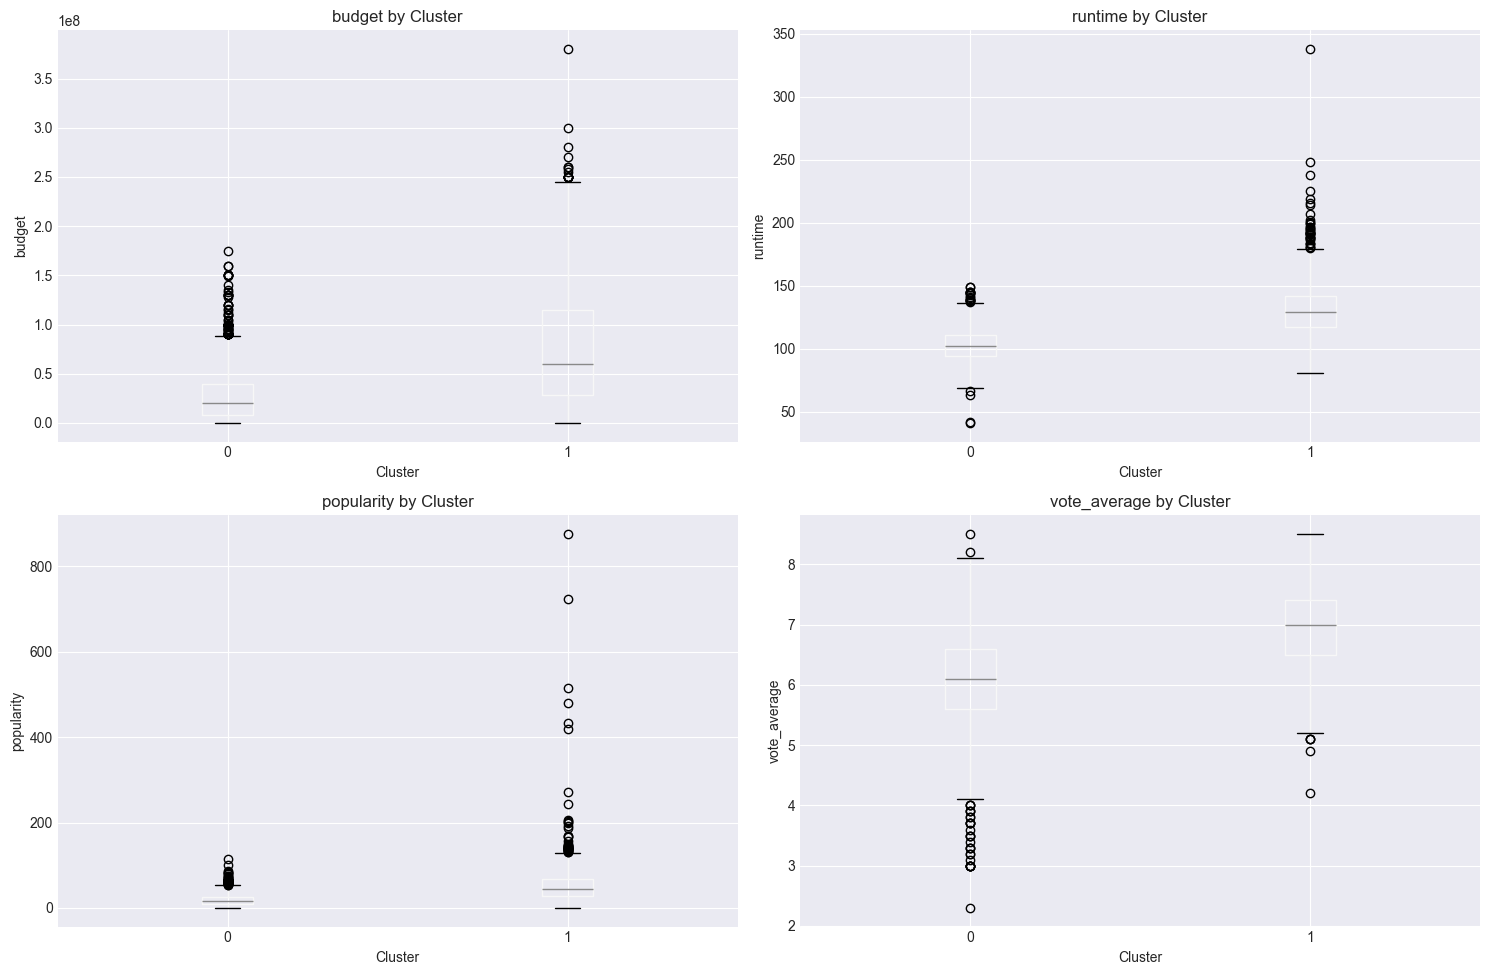

In [ ]:
# 클러스터별 특성 시각화 (박스플롯)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for idx, feature in enumerate(clustering_features):
    row = idx // 2
    col = idx % 2

    df_clean.boxplot(column=feature, by='cluster', ax=axes[row, col])
    axes[row, col].set_title(f'{feature} by Cluster')
    axes[row, col].set_xlabel('Cluster')
    axes[row, col].set_ylabel(feature)

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

### 7. 클러스터 시각화 (PCA 2D)

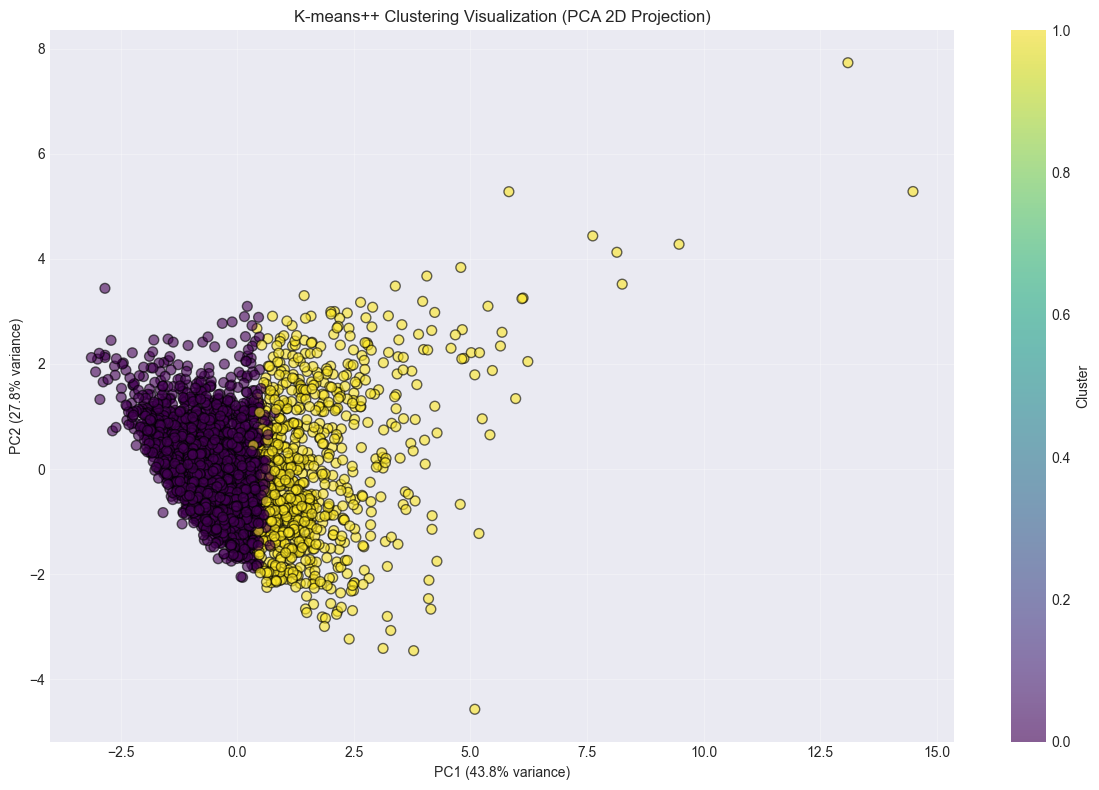


PCA 설명 분산 비율: PC1=43.78%, PC2=27.83%
총 설명 분산: 71.61%


In [ ]:
# PCA로 2차원으로 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

# 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=50, edgecolors='black')
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('K-means++ Clustering Visualization (PCA 2D Projection)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPCA 설명 분산 비율: PC1={pca.explained_variance_ratio_[0]*100:.2f}%, PC2={pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"총 설명 분산: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# **(1)에서의 문제점**

- **Silhouette Score가 0.3495로, 군집 간 경계가 모호하다는 문제가 있음**

- 그 이유 중 첫 번째로는, 군집화를 하는 데 적용된 feature의 수가 4개로 상당히 적으며 각 feature가 군집을 명확히 구별할 만큼 변별력이 높지 않았다는 것, 두 번째로는 budget 중 극단값($380 Million)은 7.64σ에 해당되어 StandardScaler에서 이러한 극단값이 전체 스케일에 왜곡을 불러 일으켰다는 것을 꼽을 수 있음.

- 다만, 영화 데이터셋에서 수치 연속형 feature가 거의 없다는 점으로 보아 군집화를 하는데 적용할 feature의 수를 더 늘리는 것은 어려우며, 중앙값과 IQR를 사용하는 RobustScaler를 통해 이상치에 강건한 스케일링을 할 수 있도록 하여 군집화하는 것이 현실적인 해결책으로 보임

### → **(2)** RobustScaler를 사용해서 문제 해결 시도


---

### **(2) RobustScaler를 사용한 군집화**

### 1. 클러스터링을 위한 데이터 준비

In [ ]:
clustering_features = ['budget', 'runtime', 'popularity', 'vote_average']
X_cluster = df_clean[clustering_features].copy()
print(f"\n=== K-means++ 클러스터링 데이터 ===")
print(f"샘플 수: {len(X_cluster):,}개")
print(f"특징: {clustering_features}")
print(f"\n기본 통계:")
print(X_cluster.describe())


=== K-means++ 클러스터링 데이터 ===
샘플 수: 3,225개
특징: ['budget', 'runtime', 'popularity', 'vote_average']

기본 통계:
             budget      runtime   popularity  vote_average
count  3.225000e+03  3225.000000  3225.000000    3225.00000
mean   4.070121e+07   110.723411    29.069419       6.31355
std    4.440431e+07    20.973909    36.173911       0.85985
min    1.000000e+00    41.000000     0.019984       2.30000
25%    1.050000e+07    96.000000    10.484642       5.80000
50%    2.500000e+07   107.000000    20.428237       6.30000
75%    5.500000e+07   121.000000    37.355826       6.90000
max    3.800000e+08   338.000000   875.581305       8.50000


### 2. 데이터 스케일링

In [ ]:
# StandardScaler 대신 RobustScaler 적용
scaler = RobustScaler()

X_cluster_scaled = scaler.fit_transform(X_cluster)

print("\nRobustScaler 적용 됨")
print(f"스케일링 후 평균: {X_cluster_scaled.mean(axis=0)}")
print(f"스케일링 후 표준편차: {X_cluster_scaled.std(axis=0)}")


RobustScaler 적용 됨
스케일링 후 평균: [0.35283618 0.14893643 0.32157802 0.01231853]
스케일링 후 표준편차: [0.99769502 0.83882628 1.34598839 0.78156048]


### 3. 최적 클러스터 수 결정 (Elbow Method)

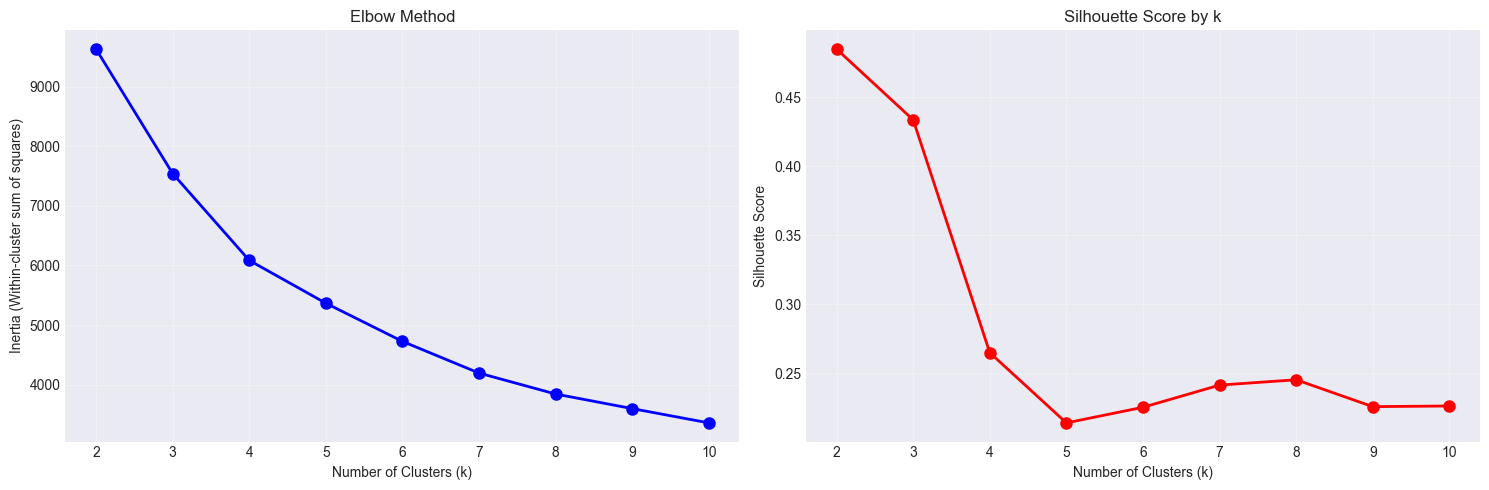


최적 클러스터 수 (Silhouette Score 기준): k = 2
최고 Silhouette Score: 0.4848


In [ ]:
# Elbow Method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Curve
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0].set_title('Elbow Method')
axes[0].grid(alpha=0.3)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score by k')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 최적 k 찾기
best_k = K_range[np.argmax(silhouette_scores)]
print(f"\n최적 클러스터 수 (Silhouette Score 기준): k = {best_k}")
print(f"최고 Silhouette Score: {max(silhouette_scores):.4f}")

### 4. K-means++ 클러스터링 수행

In [ ]:
# 인덱스 리셋 및 클러스터링
df_clean = df_clean.reset_index(drop=True)
X_cluster = df_clean[clustering_features].copy()
X_cluster_scaled = scaler.transform(X_cluster)

kmeans_final = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_cluster_scaled)
df_clean['cluster'] = cluster_labels

print(f"\nK-means++ 클러스터링 (k={best_k})")
print(f"\n클러스터별 영화 수:")
print(df_clean['cluster'].value_counts().sort_index())


K-means++ 클러스터링 (k=2)

클러스터별 영화 수:
cluster
0    2774
1     451
Name: count, dtype: int64


### 5. 클러스터 평가

In [ ]:
# 평가 지표 계산
silhouette = silhouette_score(X_cluster_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(X_cluster_scaled, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_cluster_scaled, cluster_labels)

print("\n=== 클러스터링 평가 지표 ===")
print(f"Silhouette Score: {silhouette:.4f} (높을수록 좋음, -1~1)")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f} (낮을수록 좋음)")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.2f} (높을수록 좋음)")


=== 클러스터링 평가 지표 ===
Silhouette Score: 0.4848 (높을수록 좋음, -1~1)
Davies-Bouldin Index: 1.1466 (낮을수록 좋음)
Calinski-Harabasz Score: 1224.96 (높을수록 좋음)


### 6. 클러스터별 특성 분석

In [ ]:
# 클러스터별 평균값
cluster_analysis = df_clean.groupby('cluster')[clustering_features + ['roi', 'profit', 'hit']].mean()

print("\n=== 클러스터별 평균 특성 ===")
print(cluster_analysis.round(2))

# 클러스터별 영화 수
cluster_counts = df_clean['cluster'].value_counts().sort_index()
cluster_analysis['count'] = cluster_counts

print("\n=== 클러스터별 영화 수 ===")
print(cluster_counts)


=== 클러스터별 평균 특성 ===
               budget  runtime  popularity  vote_average        roi  \
cluster                                                               
0        2.869051e+07   108.50       20.59          6.24  343766.75   
1        1.145763e+08   124.41       81.21          6.75     400.44   

               profit   hit  
cluster                      
0        4.426282e+07  0.52  
1        3.047544e+08  0.78  

=== 클러스터별 영화 수 ===
cluster
0    2774
1     451
Name: count, dtype: int64


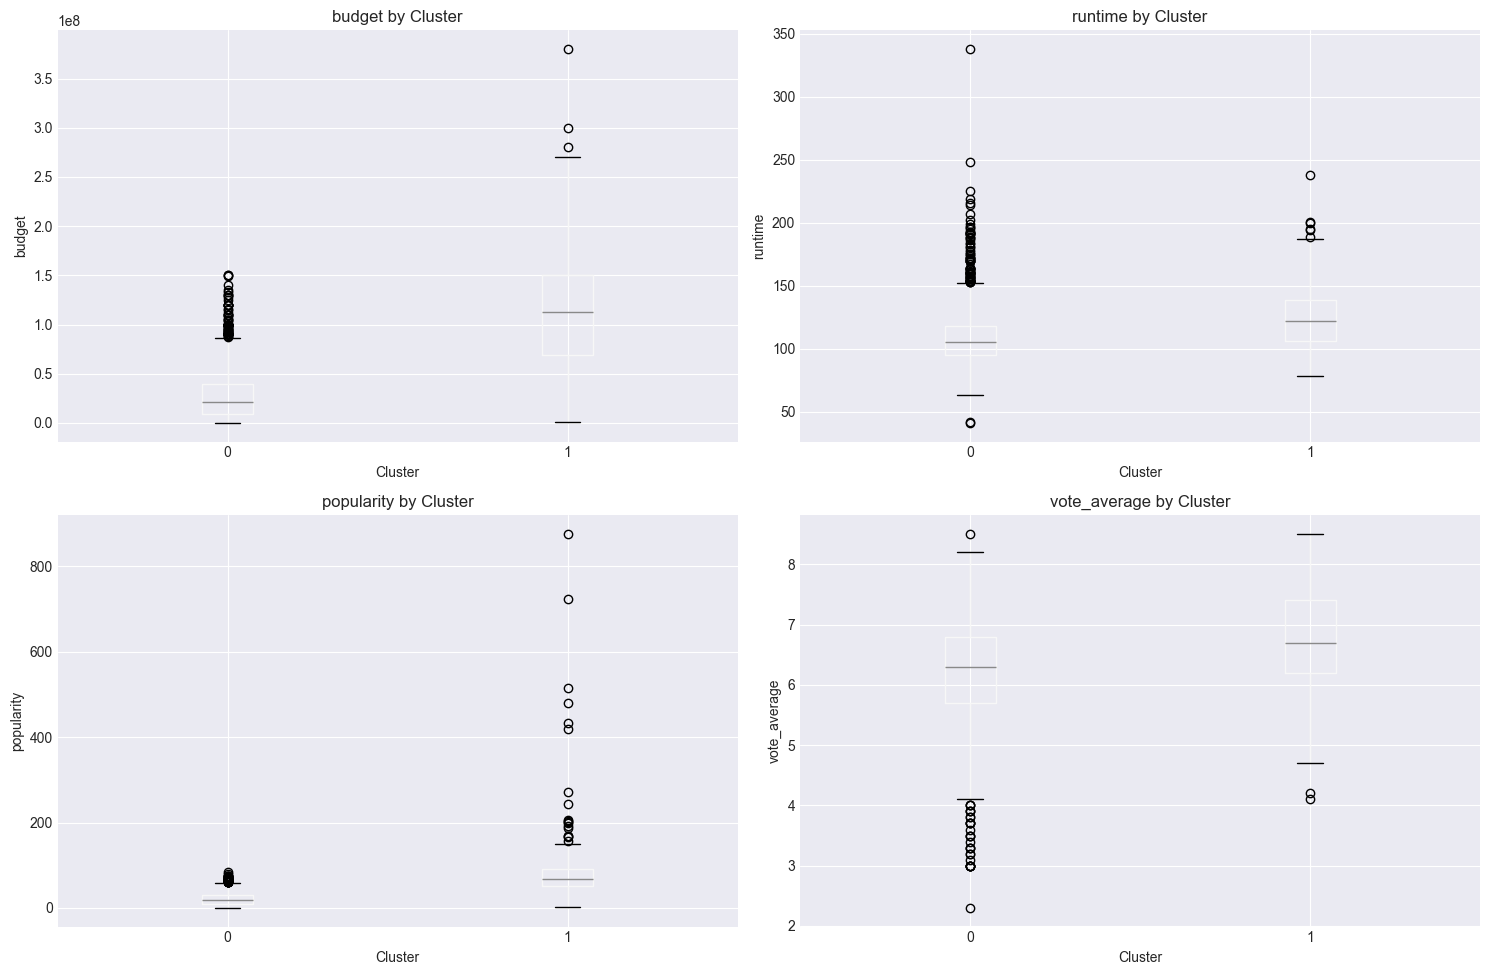

In [ ]:
# 클러스터별 특성 시각화 (박스플롯)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for idx, feature in enumerate(clustering_features):
    row = idx // 2
    col = idx % 2

    df_clean.boxplot(column=feature, by='cluster', ax=axes[row, col])
    axes[row, col].set_title(f'{feature} by Cluster')
    axes[row, col].set_xlabel('Cluster')
    axes[row, col].set_ylabel(feature)

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

### 7. 클러스터 시각화 (PCA 2D)

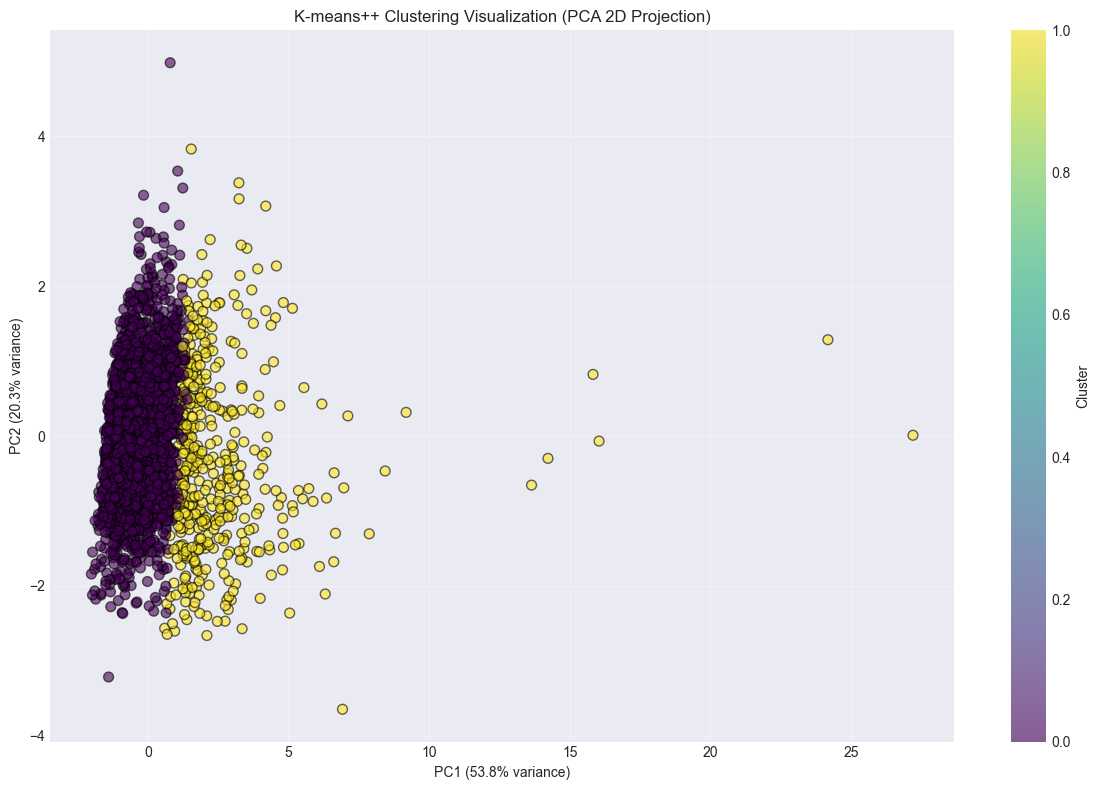


PCA 설명 분산 비율: PC1=53.84%, PC2=20.26%
총 설명 분산: 74.10%


In [ ]:
# PCA로 2차원으로 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

# 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=50, edgecolors='black')
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('K-means++ Clustering Visualization (PCA 2D Projection)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPCA 설명 분산 비율: PC1={pca.explained_variance_ratio_[0]*100:.2f}%, PC2={pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"총 설명 분산: {sum(pca.explained_variance_ratio_)*100:.2f}%")

### 8. 클러스터 해석 및 대표 영화

In [ ]:
# 각 클러스터의 대표 영화 (센트로이드에 가장 가까운 영화)
from scipy.spatial.distance import cdist

# 센트로이드와의 거리 계산
centroids = kmeans_final.cluster_centers_
distances = cdist(X_cluster_scaled, centroids, 'euclidean')

print("\n=== 각 클러스터의 대표 영화 (센트로이드에 가장 가까운 영화 3개) ===")
for cluster_id in range(best_k):
    # 해당 클러스터의 영화들
    cluster_movies = df_clean[df_clean['cluster'] == cluster_id]
    cluster_indices = cluster_movies.index

    # 센트로이드와의 거리
    cluster_distances = distances[cluster_indices, cluster_id]

    # 가장 가까운 3개 영화
    closest_indices = cluster_indices[np.argsort(cluster_distances)[:3]]

    print(f"\n--- Cluster {cluster_id} ---")
    print(f"영화 수: {len(cluster_movies)}개")
    print(f"평균 제작비: ${cluster_movies['budget'].mean():,.0f}")
    print(f"평균 수익: ${cluster_movies['revenue'].mean():,.0f}")
    print(f"평균 ROI: {cluster_movies['roi'].mean():.1f}%")
    print(f"평균 평점: {cluster_movies['vote_average'].mean():.2f}")
    print(f"흥행 비율: {cluster_movies['hit'].mean()*100:.1f}%")
    print(f"\n대표 영화:")
    for idx in closest_indices:
        movie = df_clean.loc[idx]
        print(f"  - {movie['title']} ({movie['release_year']:.0f})")
        print(f"    제작비: ${movie['budget']:,.0f}, 수익: ${movie['revenue']:,.0f}, 평점: {movie['vote_average']:.1f}")


=== 각 클러스터의 대표 영화 (센트로이드에 가장 가까운 영화 3개) ===

--- Cluster 0 ---
영화 수: 2774개
평균 제작비: $28,690,510
평균 수익: $72,953,335
평균 ROI: 343766.7%
평균 평점: 6.24
흥행 비율: 52.5%

대표 영화:
  - How to Lose Friends & Alienate People (2008)
    제작비: $27,000,000, 수익: $17,286,299, 평점: 6.2
  - Mindhunters (2004)
    제작비: $27,000,000, 수익: $21,148,829, 평점: 6.3
  - Case 39 (2009)
    제작비: $27,000,000, 수익: $29,000,000, 평점: 6.1

--- Cluster 1 ---
영화 수: 451개
평균 제작비: $114,576,335
평균 수익: $419,330,756
평균 ROI: 400.4%
평균 평점: 6.75
흥행 비율: 78.5%

대표 영화:
  - Cars (2006)
    제작비: $120,000,000, 수익: $461,983,149, 평점: 6.6
  - Sherlock Holmes: A Game of Shadows (2011)
    제작비: $125,000,000, 수익: $334,615,000, 평점: 7.0
  - Ocean's Twelve (2004)
    제작비: $110,000,000, 수익: $362,744,280, 평점: 6.4


### 9. 클러스터 명명 및 해석

In [ ]:
# 클러스터 명명 함수 (3단계 규칙)
def name_cluster(df_clean, cluster_id):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]

    # 제작비 규모
    avg_budget = cluster_data['budget'].mean()
    if avg_budget < 20e6:
        budget_tier = "Low-Budget"
    elif avg_budget < 60e6:
        budget_tier = "Mid-Budget"
    else:
        budget_tier = "High-Budget"

    # 흥행 성공률
    hit_rate = cluster_data['hit'].mean()
    if hit_rate > 0.65:
        success_tier = "High Success"
    elif hit_rate > 0.5:
        success_tier = "Moderate Success"
    else:
        success_tier = "Low Success"

    # 주요 장르
    genre_cols = [col for col in df_clean.columns if col.startswith('genre_')]
    genre_dist = cluster_data[genre_cols].mean().sort_values(ascending=False)
    top_genre = genre_dist.index[0].replace('genre_', '')

    return f"{budget_tier} {success_tier} ({top_genre}-heavy)"


# 클러스터별 명명 및 분석
cluster_names = {}

print("\n=== 클러스터 명명 및 특성 분석 ===\n")

for cluster_id in range(best_k):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    cluster_names[cluster_id] = name_cluster(df_clean, cluster_id)

    print(f"Cluster {cluster_id}: {cluster_names[cluster_id]}")
    print(f"  영화 수: {len(cluster_data):,}개 ({len(cluster_data)/len(df_clean)*100:.1f}%)")
    print(f"  평균 제작비: ${cluster_data['budget'].mean():,.0f}")
    print(f"  평균 수익: ${cluster_data['revenue'].mean():,.0f}")
    print(f"  평균 평점: {cluster_data['vote_average'].mean():.2f}")
    print(f"  흥행 성공률: {cluster_data['hit'].mean()*100:.1f}%")

    # 장르 분포 Top 3
    genre_cols = [col for col in df_clean.columns if col.startswith('genre_')]
    genre_dist = cluster_data[genre_cols].mean().sort_values(ascending=False)
    genres_str = ", ".join([f"{g.replace('genre_', '')} ({v*100:.1f}%)"
                            for g, v in genre_dist.head(3).items()])
    print(f"  주요 장르: {genres_str}")
    print()


=== 클러스터 명명 및 특성 분석 ===

Cluster 0: Mid-Budget Moderate Success (Drama-heavy)
  영화 수: 2,774개 (86.0%)
  평균 제작비: $28,690,510
  평균 수익: $72,953,335
  평균 평점: 6.24
  흥행 성공률: 52.5%
  주요 장르: Drama (47.0%), Comedy (36.8%), Thriller (28.6%)

Cluster 1: High-Budget High Success (Adventure-heavy)
  영화 수: 451개 (14.0%)
  평균 제작비: $114,576,335
  평균 수익: $419,330,756
  평균 평점: 6.75
  흥행 성공률: 78.5%
  주요 장르: Adventure (51.9%), Action (51.7%), Drama (29.7%)

